In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Path to the images directory
images_path = 'PP_Micro'  # Adjust this path to your specific setup

# Function to load images from a directory
def load_images_from_folder(folder):
    images = []
    labels = []
    file_names = [f for f in os.listdir(folder) if f.endswith(('.png', '.jpg', '.jpeg'))]
    for filename in file_names:
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            images.append(img)
            labels.append(filename.split('_')[0])  # Assuming filename format is 'label_id.jpg'
    return images, labels

# Function to preprocess images
def preprocess_images(images, size=(224, 224)):
    images_resized = [cv2.resize(img, size) for img in images]
    images_normalized = np.array(images_resized) / 255.0  # Normalize pixel values
    return images_normalized



Label
Euglena       100
Paramecium    100
Road           85
Spherical      80
Hydra          75
Spiral         75
Amoeba         70
Yeast          70
Name: count, dtype: int64


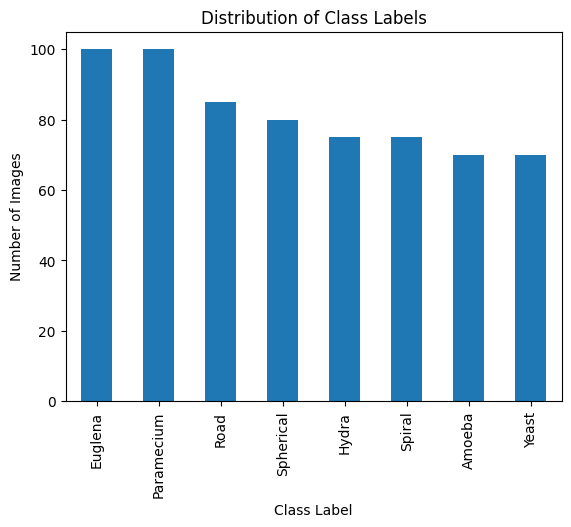

In [2]:
import os
import pandas as pd

# Path to your image directory
directory_path = 'PP_Micro/'

# List all files in the directory
files = os.listdir(directory_path)

# Extract class labels
labels = [files.split('_')[0] for files in os.listdir(directory_path) if files.endswith(('.png', '.jpg', '.jpeg'))]

# Convert to DataFrame for easier analysis
df = pd.DataFrame(labels, columns=['Label'])

# Display distribution of labels
print(df['Label'].value_counts())

# Plot a bar chart of the distribution
df['Label'].value_counts().plot(kind='bar')
plt.xlabel('Class Label')
plt.ylabel('Number of Images')
plt.title('Distribution of Class Labels')
plt.show()


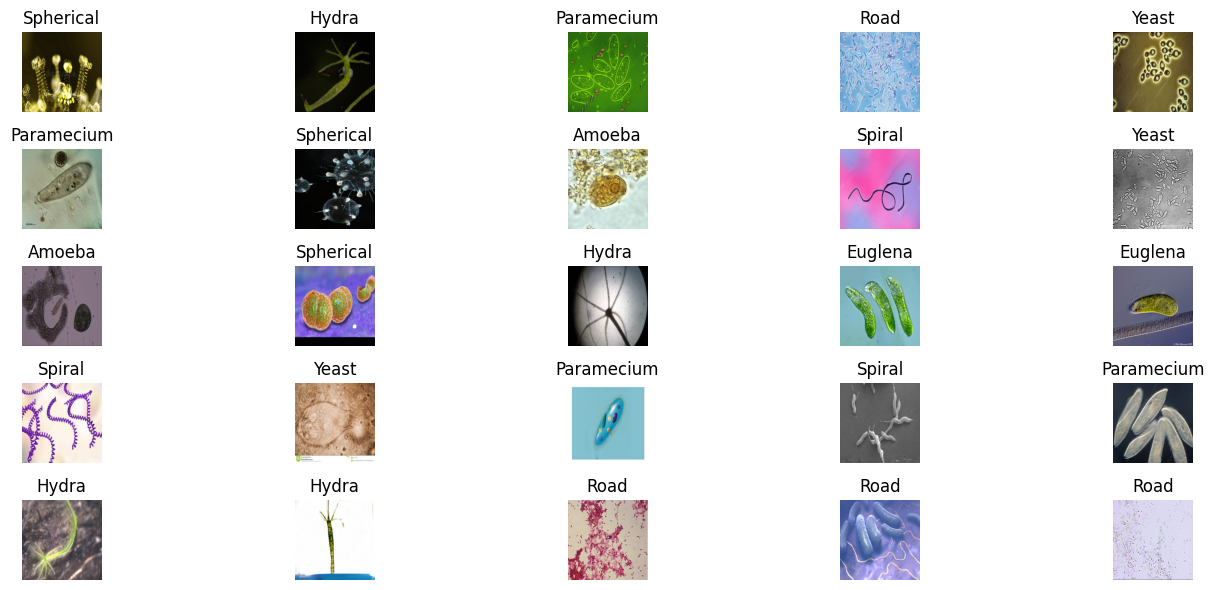

In [5]:
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# Path to your image directory
directory_path = 'PP_Micro/'

# List all files in the directory
files = [file for file in os.listdir(directory_path) if file.endswith(('.png', '.jpg', '.jpeg'))]

# Extract class labels
labels = [file.split('_')[0] for file in files]

# Combine files and labels into a DataFrame
df = pd.DataFrame({
    'File': files,
    'Label': labels
})

# Display images with their labels
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15, 6))  # Adjust the grid size based on your needs
axes = axes.flatten()

for ax, (file, label) in zip(axes, df.sample(n=25).values):  # Adjust number of samples to display as needed
    img_path = os.path.join(directory_path, file)
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis('off')  # Hide axes
    ax.set_title(label)

plt.tight_layout()
plt.show()


In [3]:
# Load and preprocess images
from tensorflow.keras.utils import to_categorical
images, labels = load_images_from_folder(images_path)
images_preprocessed = preprocess_images(images)

# Encode labels - simple numerical encoding and convert to one-hot
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)
labels_one_hot = to_categorical(labels_encoded)

In [4]:
print(labels_one_hot.shape)
print(images_preprocessed.shape)

(655, 8)
(655, 224, 224, 3)


In [5]:
import numpy as np
from sklearn.model_selection import KFold, train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load ResNet50 base model without the top
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
base_model.trainable = False

# Create a new model on top
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(8, activation='softmax')  # Assuming 3 classes for the task
])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ ?                      │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,037,504 (26.85 MB)

In [6]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=0.001,
    verbose=1
)

In [7]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [8]:
import numpy as np
from sklearn.model_selection import KFold, train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Configuration
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

X_train, X_test, Y_train, Y_test = train_test_split(images_preprocessed, labels_one_hot, test_size=0.25, random_state=42)

# Prepare to collect scores
fold_no = 1
loss_per_fold = []
accuracy_per_fold = []

for train_idx, val_idx in kfold.split(X_train, Y_train):
    print(f'Training fold {fold_no}...')
    
    # Split data
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = Y_train[train_idx], Y_train[val_idx]

    # Fit the model
    history = model.fit(
        X_train_fold, y_train_fold,
        batch_size=16,
        epochs=20,
        verbose=1,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[early_stopping, reduce_lr]
    )

    # Evaluate the model
    scores = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f'Score for fold {fold_no}: Loss = {scores[0]}; Accuracy = {scores[1]*100}%')
    loss_per_fold.append(scores[0])
    accuracy_per_fold.append(scores[1] * 100)

    # Increment the fold number
    fold_no += 1

# Provide average scores
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(accuracy_per_fold)):
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {accuracy_per_fold[i]}%')
print('------------------------------------------------------------------------')
print(f'Average scores for all folds: Accuracy: {np.mean(accuracy_per_fold):.2f}%, Loss: {np.mean(loss_per_fold):.2f}')
print('------------------------------------------------------------------------')


Training fold 1...
Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 454ms/step - accuracy: 0.2878 - loss: 2.6448 - val_accuracy: 0.4848 - val_loss: 1.5736 - learning_rate: 0.0010
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 357ms/step - accuracy: 0.6979 - loss: 1.0299 - val_accuracy: 0.5859 - val_loss: 1.1003 - learning_rate: 0.0010
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 363ms/step - accuracy: 0.7483 - loss: 0.7478 - val_accuracy: 0.6263 - val_loss: 1.2759 - learning_rate: 0.0010
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 366ms/step - accuracy: 0.7909 - loss: 0.6078 - val_accuracy: 0.5758 - val_loss: 1.2506 - learning_rate: 0.0010
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 362ms/step - accuracy: 0.8311 - loss: 0.3833 - val_accuracy: 0.5657 - val_loss: 1.2438 - learning_rate: 0.0010
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 386ms/step - accuracy: 0.8970 - loss: 0.2960 - val_accuracy: 0.5758 - val_loss: 1.2740 - learning_rate: 0.0010
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 378ms/step - accuracy: 0.8

In [9]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_val_fold, y_val_fold)
print(f"Validation accuracy: {test_accuracy}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 441ms/step - accuracy: 0.9320 - loss: 0.2630
Validation accuracy: 0.9081632494926453


In [12]:
# # Evaluate the model on the test set
# test_loss, test_accuracy = model.evaluate(X_test, Y_test)
# print(f"Validation accuracy: {test_accuracy}")

In [13]:
scores = model.evaluate(X_val_fold, y_val_fold, verbose=0)
print(scores)

[0.30670830607414246, 0.9081632494926453]


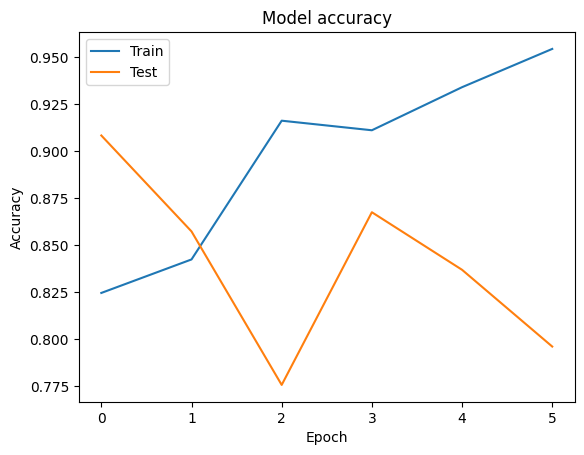

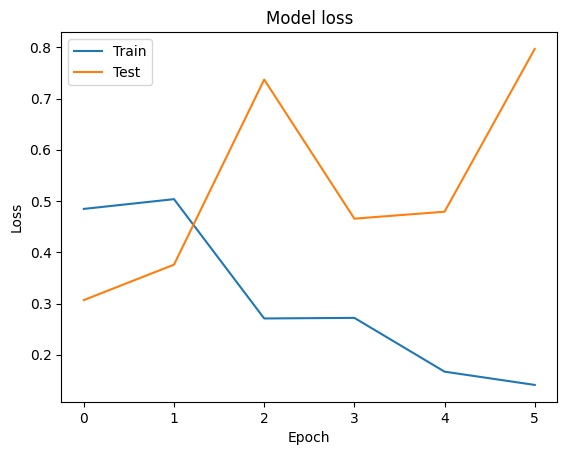

In [14]:
# Plot training & test accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & test loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [17]:
from sklearn.metrics import classification_report

print(classification_report(np.argmax(y_val_fold, axis=1), np.argmax(model.predict(X_val_fold),axis=1)))

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 421ms/step
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       0.85      1.00      0.92        11
           2       1.00      0.94      0.97        18
           3       1.00      0.73      0.85        15
           4       0.89      1.00      0.94        16
           5       1.00      0.73      0.84        11
           6       0.75      0.86      0.80         7
           7       0.91      1.00      0.95        10

    accuracy                           0.91        98
   macro avg       0.90      0.91      0.90        98
weighted avg       0.92      0.91      0.91        98



4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 526ms/step


<Axes: xlabel='Predicted', ylabel='Actual'>

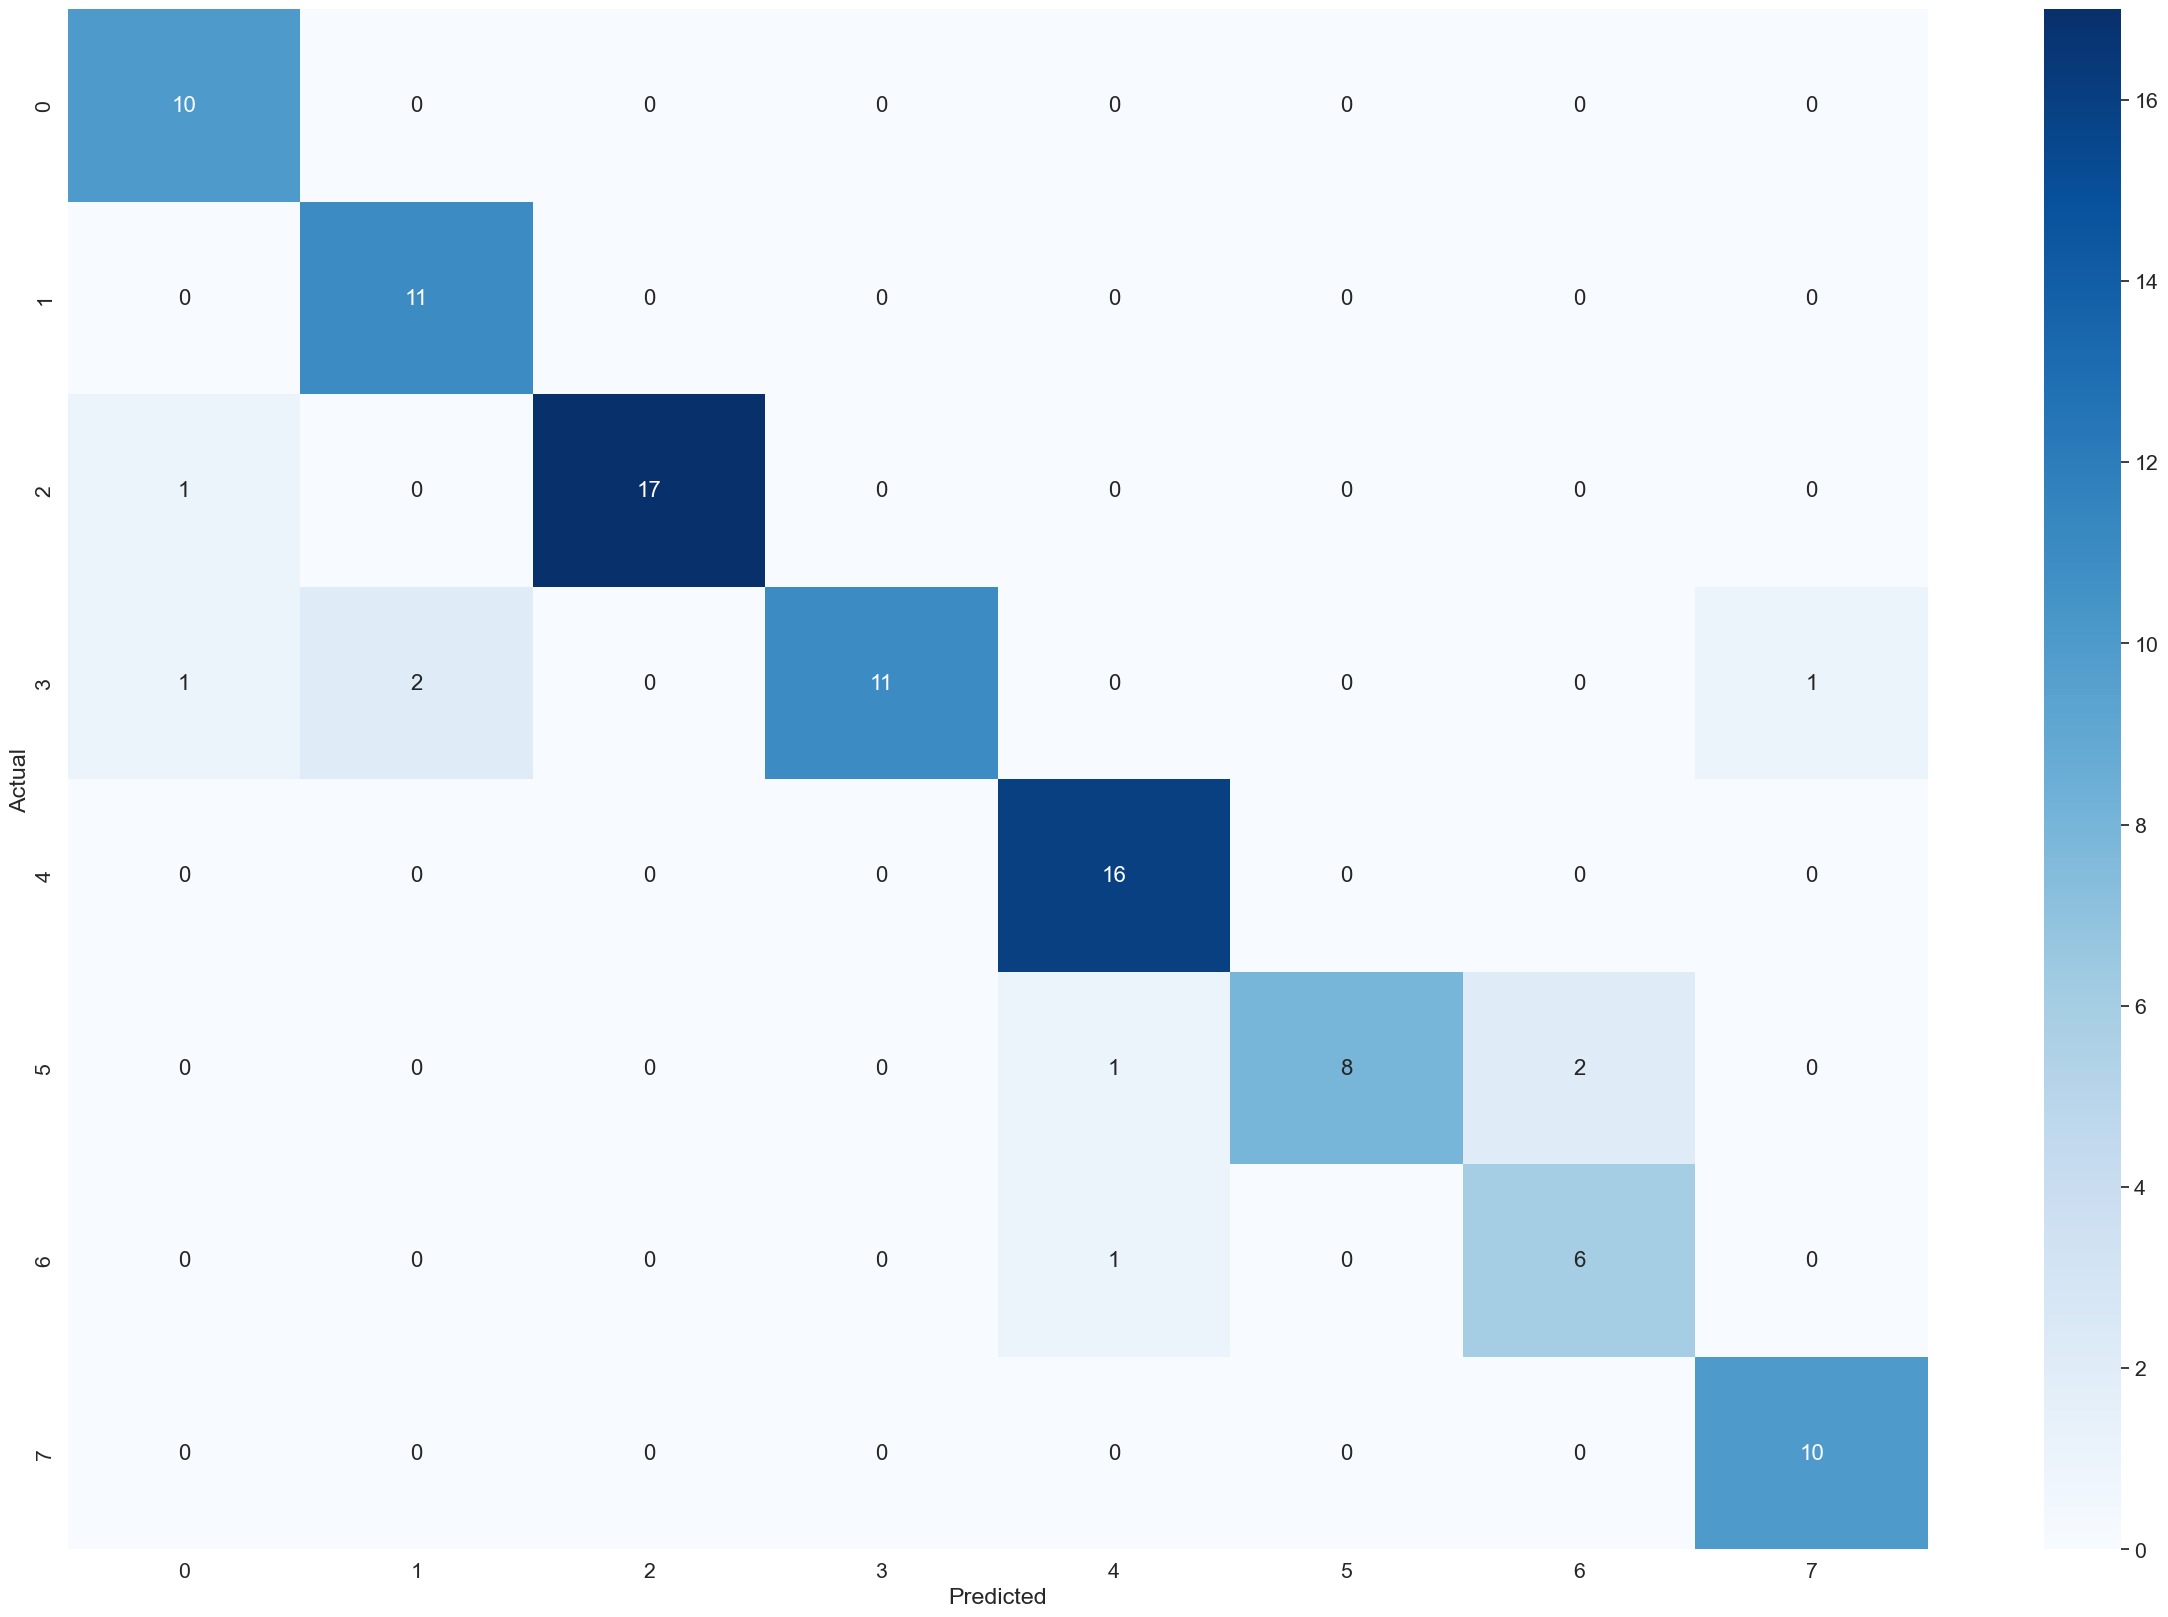

In [18]:
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score
import seaborn as sn
import pandas as pd
y_true = np.argmax(y_val_fold, axis=1)
y_pred = np.argmax(model.predict(X_val_fold), axis=1)
data = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (30,20))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


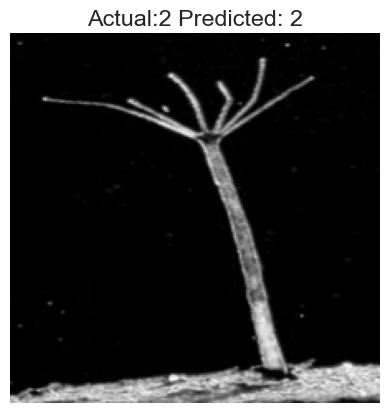

In [19]:
rand_n = np.random.randint(X_val_fold.shape[0])
plt.imshow(X_val_fold[rand_n][:, :, 0], cmap='gray')
plt.title(f'Actual:{np.argmax(y_val_fold[rand_n])} Predicted: {np.argmax(model.predict(X_val_fold[rand_n].reshape(-1, 224, 224, 3)))}');
plt.axis('off')
plt.show()